# Project03_Deep Learning

## Step 0: Data (MNIST in PyTorch & face data in project_01)

In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import random

### MNIST data

Transform that allows images to have the same dimensions and properties.

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

Using MNIST data and  loading them to DataLoader, 
which combines the dataset and a sampler and provides single or multi-process iterators over the dataset.

In [3]:
trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

Visualize data

In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


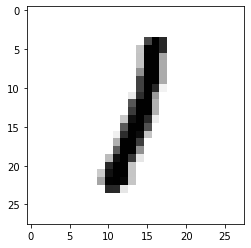

In [5]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

Visualize more data

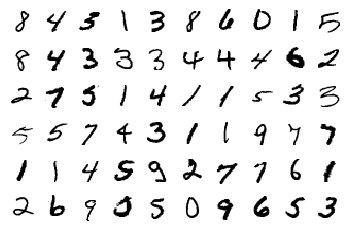

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

Build up neural network, to start with, we simply select 3 fully connected layers, input size is 784 since MNIST with size 28x28.
Pytorch already has the nn.Sequential and nn.Linear that contains intial activated weights.

In [7]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax()
)


Define loss

In [8]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

Check initial weights and the weights after back propagation.

In [9]:
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[ 0.0025,  0.0025,  0.0025,  ...,  0.0025,  0.0025,  0.0025],
        [-0.0019, -0.0019, -0.0019,  ..., -0.0019, -0.0019, -0.0019],
        [-0.0009, -0.0009, -0.0009,  ..., -0.0009, -0.0009, -0.0009],
        ...,
        [ 0.0001,  0.0001,  0.0001,  ...,  0.0001,  0.0001,  0.0001],
        [-0.0002, -0.0002, -0.0002,  ..., -0.0002, -0.0002, -0.0002],
        [-0.0045, -0.0045, -0.0045,  ..., -0.0045, -0.0045, -0.0045]])


Training the model

In [10]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 20
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.6443143629633796
Epoch 1 - Training loss: 0.28564319600746324
Epoch 2 - Training loss: 0.22238148582864925
Epoch 3 - Training loss: 0.17842848336042116
Epoch 4 - Training loss: 0.15066149639192103
Epoch 5 - Training loss: 0.13172752643798366
Epoch 6 - Training loss: 0.1151032801439513
Epoch 7 - Training loss: 0.10100816600699859
Epoch 8 - Training loss: 0.09112063679309972
Epoch 9 - Training loss: 0.08079394316032672
Epoch 10 - Training loss: 0.0739028223408962
Epoch 11 - Training loss: 0.069940632625199
Epoch 12 - Training loss: 0.0626286608916618
Epoch 13 - Training loss: 0.058651418078379
Epoch 14 - Training loss: 0.05190778831973163
Epoch 15 - Training loss: 0.04919764699850247
Epoch 16 - Training loss: 0.0453115449180759
Epoch 17 - Training loss: 0.04271494643042869
Epoch 18 - Training loss: 0.038887764772907625
Epoch 19 - Training loss: 0.03608061366469792

Training Time (in minutes) = 4.5216048002243046


Training process is relatively low. Testing on the validation set

In [11]:
images, labels = next(iter(valloader))
img = images[0].view(1, 784)
with torch.no_grad():
    logps = model(img)
ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))

Predicted Digit = 8


True label is:

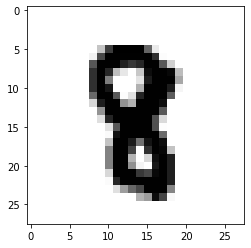

In [12]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

Iterate through all validation set and calculate the validation accuracy

In [13]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.977


Now let's test on our own face dataset.

### Face Dataset from project01

Face dataset is stored in the same path of Notebook, and named "images", there are two folders in the images:
    0.nonface
    1.face
Each picture is sized to 3x28x28, totally we have 1000 face pictures and 1000 nonface pifctures, load these data.

In [14]:
train_data = datasets.ImageFolder('images',transform=transform)

Seperate data set into training set validation set, and testset. 

In [15]:
num_data = len(train_data)
indices_data = list(range(num_data))
np.random.shuffle(indices_data)
split_tt = int(np.floor(0.1 * num_data))
train_idx, test_idx = indices_data[split_tt:], indices_data[:split_tt]

In [16]:
num_train = len(train_idx)
indices_train = list(range(num_train))
np.random.shuffle(indices_train)
split_tv = int(np.floor(0.25 * num_train))
train_idx, valid_idx = indices_train[split_tv:],indices_train[:split_tv]

In [17]:
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [18]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, sampler=train_sampler, num_workers=1)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=32, sampler=valid_sampler, num_workers=1)
test_loader = torch.utils.data.DataLoader(train_data, batch_size=32, sampler = test_sampler, num_workers=1)

Visualize our face dataset

In [19]:
face_dataiter = iter(train_loader)
fake_img, labels = face_dataiter.next()
images = fake_img[:,0,:,:]
print(images.shape)
print(labels.shape)

torch.Size([32, 28, 28])
torch.Size([32])


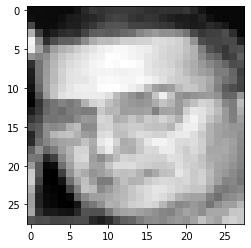

In [20]:
plt.imshow(images[1].numpy().squeeze(), cmap='binary_r');

Visualize more face data.

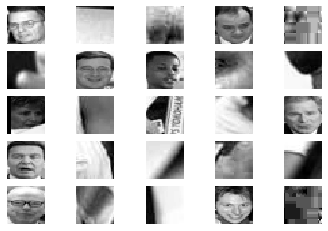

In [21]:
figure = plt.figure()
num_of_images = 25
for index in range(1, num_of_images + 1):
    plt.subplot(5, 5, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(),cmap = 'binary_r')

Due to figure size is 3x28x28, so the input size will be 2352, still keep the other model structure the same
Output size became 2, since it is a binary classification.

In [22]:
input_sizez = 2352
hidden_sizes = [128, 64]
output_size = 2
model = nn.Sequential(nn.Linear(input_sizez, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=2352, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=2, bias=True)
  (5): LogSoftmax()
)


In [23]:
criterion = nn.NLLLoss()
images, labels = next(iter(train_loader))
images = images.view(images.shape[0], -1)
logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [24]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 20
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        # Flatten face images into a 2352 long vector
        images = images.view(images.shape[0], -1)
        # Training pass
        optimizer.zero_grad() 
        output = model(images)
        loss = criterion(output, labels)
        #This is where the model learns by backpropagating
        loss.backward()
        #And optimizes its weights here
        optimizer.step()
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(train_loader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.595317869685417
Epoch 1 - Training loss: 0.39219193056572316
Epoch 2 - Training loss: 0.2919497164182885
Epoch 3 - Training loss: 0.23771333417227103
Epoch 4 - Training loss: 0.19806242474289829
Epoch 5 - Training loss: 0.16837791769310487
Epoch 6 - Training loss: 0.14453540023329647
Epoch 7 - Training loss: 0.12786849401891232
Epoch 8 - Training loss: 0.1105099177031323
Epoch 9 - Training loss: 0.09869056524232377
Epoch 10 - Training loss: 0.08931987507398738
Epoch 11 - Training loss: 0.0826917766311834
Epoch 12 - Training loss: 0.07263115702500177
Epoch 13 - Training loss: 0.06184327795148589
Epoch 14 - Training loss: 0.05167620494788469
Epoch 15 - Training loss: 0.04497996890960738
Epoch 16 - Training loss: 0.041614581949922236
Epoch 17 - Training loss: 0.04177706049711898
Epoch 18 - Training loss: 0.06395655918086685
Epoch 19 - Training loss: 0.03453907900663136

Training Time (in minutes) = 0.6214232126871745


Now let's test on testset. 0 is nonface, 1 is face

In [25]:
test_images, test_labels = next(iter(test_loader))
img = test_images[0].view(1, 2352)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted =", probab.index(max(probab)))

Predicted = 0


True label is:

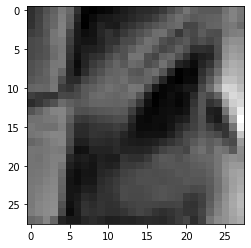

In [26]:
plt.imshow(test_images[0,0,:,:].numpy().squeeze(), cmap='binary_r');

Correct, iterate through all testset and check the accuracy.

In [27]:
correct_count, all_count = 0, 0
for test_images,labels in test_loader:
  for i in range(len(labels)):
    img = test_images[i].view(1, 2352)
    with torch.no_grad():
        logps = model(img)
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1
print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 200

Model Accuracy = 0.975


Accuracy is so high! Actually our facedata is properly croped, so it cotains relatively few noise for model to train.
Next step, we are trying to add more noise to face dataset and check how it influence the results.

## Step 1: preprocess the data and select a data augment scheme.

Pytorch contains different data augmentation method to increase data noise. Here, we simply uses filp, rotation, perspective and bright to increase imgaes complexity, normalize dataset.

In [28]:
rgb_mean = (0.4914, 0.4822, 0.4465)
rgb_std = (0.2023, 0.1994, 0.2010)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomPerspective(),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize(rgb_mean, rgb_std)
    ])

In [29]:
train_data = datasets.ImageFolder('images',transform=transform)
num_data = len(train_data)
indices_data = list(range(num_data))
np.random.shuffle(indices_data)
split_tt = int(np.floor(0.1 * num_data))
train_idx, test_idx = indices_data[split_tt:], indices_data[:split_tt]

In [30]:
num_train = len(train_idx)
indices_train = list(range(num_train))
np.random.shuffle(indices_train)
split_tv = int(np.floor(0.25 * num_train))
train_idx, valid_idx = indices_train[split_tv:],indices_train[:split_tv]

In [31]:
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [32]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, sampler=train_sampler, num_workers=1)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=32, sampler=valid_sampler, num_workers=1)
test_loader = torch.utils.data.DataLoader(train_data, batch_size=32, sampler = test_sampler, num_workers=1)

In [33]:
face_dataiter = iter(train_loader)
fake_img, labels = face_dataiter.next()
images = fake_img[:,0,:,:]
print(images.shape)
print(labels.shape)

torch.Size([32, 28, 28])
torch.Size([32])


Plot images after data augmentation

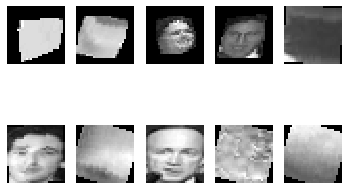

In [34]:
figure = plt.figure()
num_of_images = 10
for index in range(1, num_of_images + 1):
    plt.subplot(2, 5, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(),cmap = 'binary_r')

From above, we still could tell the face and nonface by eyes, but it is much noiser than before.
Input data to three fully connected neural network to see how data augmentation change the results.

In [35]:
input_sizez = 2352
hidden_sizes = [128, 64]
output_size = 2
model = nn.Sequential(nn.Linear(input_sizez, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=2352, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=2, bias=True)
  (5): LogSoftmax()
)


In [36]:
criterion = nn.NLLLoss()
images, labels = next(iter(train_loader))
images = images.view(images.shape[0], -1)
logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

Print out results for every 32 batches.

In [37]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 20
print_every = 32
running_loss = 0
steps = 0
t_accuracy = 0
train_losses, valid_losses = [], []
train_accuracy, valid_accuracy = [], []
for epoch in range(epochs):
    for images, labels in train_loader:
        # Flatten images into a 2352 long vector
        steps += 1
        images = images.view(images.shape[0], -1)
        # Training pass
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        #This is where the model learns by backpropagating
        loss.backward()
        #And optimizes its weights here
        optimizer.step()
        running_loss += loss.item()
        prediction = torch.exp(output)
        t_top_p, t_top_class = prediction.topk(1, dim=1)
        equality = t_top_class == labels.view(*t_top_class.shape)
        t_accuracy += torch.mean(equality.type(torch.FloatTensor)).item()
        if steps % print_every == 0:
            valid_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for valid_images, labels in valid_loader:
                    valid_images = valid_images.view(valid_images.shape[0], -1)
                    valid_output = model(valid_images)
                    batch_loss = criterion(valid_output, labels)
                    valid_loss += batch_loss.item()
                    ps = torch.exp(valid_output)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/print_every)
            valid_losses.append(valid_loss/len(valid_loader))
            train_accuracy.append(t_accuracy/print_every)
            valid_accuracy.append(accuracy/len(valid_loader))
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Train accuracy: {t_accuracy/print_every:.3f}.."
                  f"Validation loss: {valid_loss/len(valid_loader):.3f}.."
                  f"Validation accuracy: {accuracy/len(valid_loader):.3f}")
            running_loss = 0
            t_accuracy = 0
            model.train()
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 1/20.. Train loss: 0.587.. Train accuracy: 0.674..Validation loss: 0.508..Validation accuracy: 0.740
Epoch 2/20.. Train loss: 0.520.. Train accuracy: 0.730..Validation loss: 0.526..Validation accuracy: 0.656
Epoch 3/20.. Train loss: 0.501.. Train accuracy: 0.751..Validation loss: 0.412..Validation accuracy: 0.833
Epoch 3/20.. Train loss: 0.454.. Train accuracy: 0.773..Validation loss: 0.415..Validation accuracy: 0.792
Epoch 4/20.. Train loss: 0.405.. Train accuracy: 0.817..Validation loss: 0.438..Validation accuracy: 0.790
Epoch 5/20.. Train loss: 0.391.. Train accuracy: 0.812..Validation loss: 0.390..Validation accuracy: 0.823
Epoch 6/20.. Train loss: 0.391.. Train accuracy: 0.815..Validation loss: 0.462..Validation accuracy: 0.771
Epoch 6/20.. Train loss: 0.389.. Train accuracy: 0.813..Validation loss: 0.382..Validation accuracy: 0.790
Epoch 7/20.. Train loss: 0.381.. Train accuracy: 0.811..Validation loss: 0.387..Validation accuracy: 0.835
Epoch 8/20.. Train loss: 0.377.. Trai

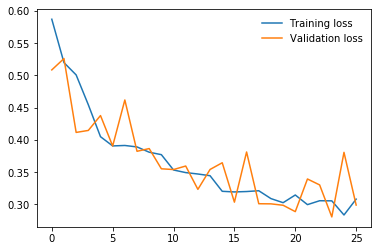

In [38]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

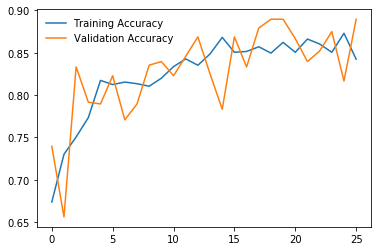

In [39]:
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(valid_accuracy, label='Validation Accuracy')
plt.legend(frameon=False)
plt.show()

In [40]:
correct_count, all_count = 0, 0
for test_images,labels in test_loader:
  for i in range(len(labels)):
    img = test_images[i].view(1, 2352)
    with torch.no_grad():
        logps = model(img)
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1
print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 200

Model Accuracy = 0.835


Compared with the method without data augmentation, with more noise, the accuracy decrease a lot, which  implies that fully connected neural network will be influenced by data noise. Now that's try more complicated neural network to test if we could still well classify face data if with some noise.

## Step 2: Choose the architecture

Previously, we simply choose three layer fully connected model, with ReLu activation, which proves to be still strong enough to classify the face data, here we apply convolutional layer, pooling, dropout and regularization to test if we could improve accuracy.

In [41]:
face_dataiter = iter(train_loader)
images, labels = face_dataiter.next()
print(images.shape)
print(labels.shape)

torch.Size([32, 3, 28, 28])
torch.Size([32])


Based on previous three fully connected layer, we apply two convolutional layer at the beginning of neural network. first layer is to extract 20 features, second layer is to extract 15 features. Select 3x3 kernel size and apply pool to squeeze the information. Using 0.2 dropout to filter the inforamtion again. The conclusion for network is shown below

In [42]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 20, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(20, 15, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout(0.1)
        self.fc1 = nn.Linear(8 * 8 * 15, 128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64, 2)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out
model = ConvNet()
print(model)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(20, 15, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=960, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)


Instead of NNLoss that is used previously, use CrossEntropyLoss here. Train the convolutional network.

In [43]:
criterion = nn.CrossEntropyLoss()
images, labels = next(iter(train_loader))
logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [44]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 20
print_every = 32
running_loss = 0
steps = 0
t_accuracy = 0
train_losses, valid_losses = [], []
train_accuracy, valid_accuracy = [], []
for epoch in range(epochs):
    for images, labels in train_loader:
        steps += 1
        # Training pass
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        #This is where the model learns by backpropagating
        loss.backward()
        #And optimizes its weights here
        optimizer.step()
        running_loss += loss.item()
        prediction = torch.exp(output)
        t_top_p, t_top_class = prediction.topk(1, dim=1)
        equality = t_top_class == labels.view(*t_top_class.shape)
        t_accuracy += torch.mean(equality.type(torch.FloatTensor)).item()
        if steps % print_every == 0:
            valid_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for valid_images, labels in valid_loader:
                    valid_output = model(valid_images)
                    batch_loss = criterion(valid_output, labels)
                    valid_loss += batch_loss.item()
                    ps = torch.exp(valid_output)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/print_every)
            valid_losses.append(valid_loss/len(valid_loader))
            train_accuracy.append(t_accuracy/print_every)
            valid_accuracy.append(accuracy/len(valid_loader))
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Train accuracy: {t_accuracy/print_every:.3f}.."
                  f"Validation loss: {valid_loss/len(valid_loader):.3f}.."
                  f"Validation accuracy: {accuracy/len(valid_loader):.3f}")
            running_loss = 0
            t_accuracy = 0
            model.train()
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 1/20.. Train loss: 0.683.. Train accuracy: 0.566..Validation loss: 0.691..Validation accuracy: 0.502
Epoch 2/20.. Train loss: 0.668.. Train accuracy: 0.563..Validation loss: 0.651..Validation accuracy: 0.621
Epoch 3/20.. Train loss: 0.623.. Train accuracy: 0.691..Validation loss: 0.570..Validation accuracy: 0.742
Epoch 3/20.. Train loss: 0.503.. Train accuracy: 0.772..Validation loss: 0.370..Validation accuracy: 0.850
Epoch 4/20.. Train loss: 0.358.. Train accuracy: 0.856..Validation loss: 0.279..Validation accuracy: 0.877
Epoch 5/20.. Train loss: 0.283.. Train accuracy: 0.898..Validation loss: 0.208..Validation accuracy: 0.935
Epoch 6/20.. Train loss: 0.264.. Train accuracy: 0.905..Validation loss: 0.240..Validation accuracy: 0.910
Epoch 6/20.. Train loss: 0.277.. Train accuracy: 0.893..Validation loss: 0.227..Validation accuracy: 0.923
Epoch 7/20.. Train loss: 0.238.. Train accuracy: 0.912..Validation loss: 0.178..Validation accuracy: 0.931
Epoch 8/20.. Train loss: 0.232.. Trai

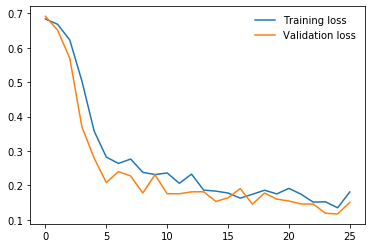

In [45]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

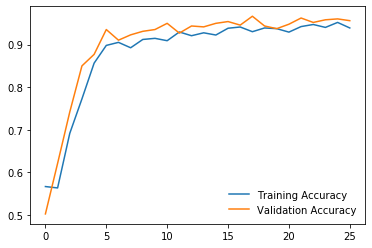

In [46]:
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(valid_accuracy, label='Validation Accuracy')
plt.legend(frameon=False)
plt.show()

The results seem to show better than simple three fully connected layer, let's try on the test set.

In [47]:
# track test loss
classes = [0,1]
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
model.eval()
i=1
# iterate over test data
len(test_loader)
for data, target in test_loader:
    i=i+1
    if len(target)!=32:
        continue
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy())
    # calculate test accuracy for each object class
#     print(target)   
    for i in range(32):       
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.009188

Test Accuracy of     0: 96% (94/97)
Test Accuracy of     1: 96% (92/95)

Test Accuracy (Overall): 96% (186/192)


So CNN did help to improve accuracy to a certain level, it extract information from noise dataset compared with the fully connected network. Next, we will follow the babysitting procedure to see how parameters will change the network.

Try with small regularization, change learning rate to 1e3.

In [48]:
model1= ConvNet()
optimizer = optim.SGD(model1.parameters(), lr=1e3, momentum=0.9, weight_decay=0.001)
time0 = time()
epochs = 15
print_every = 32
running_loss = 0
steps = 0
t_accuracy = 0
valid_loss=0
accuracy=0
train_losses, valid_losses = [], []
train_accuracy, valid_accuracy = [], []
for epoch in range(epochs):
    for images, labels in train_loader:
        steps += 1
        # Training pass
        optimizer.zero_grad()
        output = model1(images)
        loss = criterion(output, labels)
        #This is where the model learns by backpropagating
        loss.backward()
        #And optimizes its weights here
        optimizer.step()
        running_loss += loss.item()
        prediction = torch.exp(output)
        t_top_p, t_top_class = prediction.topk(1, dim=1)
        equality = t_top_class == labels.view(*t_top_class.shape)
        t_accuracy += torch.mean(equality.type(torch.FloatTensor)).item()
        if steps % print_every == 0:
            valid_loss = 0
            accuracy = 0
            model1.eval()
            with torch.no_grad():
                for valid_images, labels in valid_loader:
                    valid_output = model(valid_images)
                    batch_loss = criterion(valid_output, labels)
                    valid_loss += batch_loss.item()
                    ps = torch.exp(valid_output)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/print_every)
            valid_losses.append(valid_loss/len(valid_loader))
            train_accuracy.append(t_accuracy/print_every)
            valid_accuracy.append(accuracy/len(valid_loader))
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Train accuracy: {t_accuracy/print_every:.3f}.."
                  f"Validation loss: {valid_loss/len(valid_loader):.3f}.."
                  f"Validation accuracy: {accuracy/len(valid_loader):.3f}")
            running_loss = 0
            t_accuracy = 0
            model.train()
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 1/15.. Train loss: nan.. Train accuracy: 0.561..Validation loss: 0.146..Validation accuracy: 0.952
Epoch 2/15.. Train loss: nan.. Train accuracy: 0.565..Validation loss: 0.131..Validation accuracy: 0.963
Epoch 3/15.. Train loss: nan.. Train accuracy: 0.573..Validation loss: 0.132..Validation accuracy: 0.967
Epoch 3/15.. Train loss: nan.. Train accuracy: 0.560..Validation loss: 0.122..Validation accuracy: 0.958
Epoch 4/15.. Train loss: nan.. Train accuracy: 0.548..Validation loss: 0.146..Validation accuracy: 0.963
Epoch 5/15.. Train loss: nan.. Train accuracy: 0.596..Validation loss: 0.131..Validation accuracy: 0.958
Epoch 6/15.. Train loss: nan.. Train accuracy: 0.550..Validation loss: 0.131..Validation accuracy: 0.956
Epoch 6/15.. Train loss: nan.. Train accuracy: 0.560..Validation loss: 0.117..Validation accuracy: 0.958
Epoch 7/15.. Train loss: nan.. Train accuracy: 0.560..Validation loss: 0.161..Validation accuracy: 0.931
Epoch 8/15.. Train loss: nan.. Train accuracy: 0.555..V

No, learning rate is too high

In [49]:
model2= ConvNet()
optimizer = optim.SGD(model2.parameters(), lr=1e-6, momentum=0.9, weight_decay=0.001)
time0 = time()
epochs = 15
print_every = 32
running_loss = 0
steps = 0
t_accuracy = 0
valid_loss=0
accuracy=0
train_losses, valid_losses = [], []
train_accuracy, valid_accuracy = [], []
for epoch in range(epochs):
    for images, labels in train_loader:
        steps += 1
        # Training pass
        optimizer.zero_grad()
        output = model2(images)
        loss = criterion(output, labels)
        #This is where the model learns by backpropagating
        loss.backward()
        #And optimizes its weights here
        optimizer.step()
        running_loss += loss.item()
        prediction = torch.exp(output)
        t_top_p, t_top_class = prediction.topk(1, dim=1)
        equality = t_top_class == labels.view(*t_top_class.shape)
        t_accuracy += torch.mean(equality.type(torch.FloatTensor)).item()
        if steps % print_every == 0:
            valid_loss = 0
            accuracy = 0
            model2.eval()
            with torch.no_grad():
                for valid_images, labels in valid_loader:
                    valid_output = model(valid_images)
                    batch_loss = criterion(valid_output, labels)
                    valid_loss += batch_loss.item()
                    ps = torch.exp(valid_output)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/print_every)
            valid_losses.append(valid_loss/len(valid_loader))
            train_accuracy.append(t_accuracy/print_every)
            valid_accuracy.append(accuracy/len(valid_loader))
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Train accuracy: {t_accuracy/print_every:.3f}.."
                  f"Validation loss: {valid_loss/len(valid_loader):.3f}.."
                  f"Validation accuracy: {accuracy/len(valid_loader):.3f}")
            running_loss = 0
            t_accuracy = 0
            model.train()
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 1/15.. Train loss: 0.713.. Train accuracy: 0.453..Validation loss: 0.135..Validation accuracy: 0.963
Epoch 2/15.. Train loss: 0.722.. Train accuracy: 0.425..Validation loss: 0.171..Validation accuracy: 0.929
Epoch 3/15.. Train loss: 0.714.. Train accuracy: 0.450..Validation loss: 0.132..Validation accuracy: 0.971
Epoch 3/15.. Train loss: 0.722.. Train accuracy: 0.426..Validation loss: 0.109..Validation accuracy: 0.971
Epoch 4/15.. Train loss: 0.718.. Train accuracy: 0.433..Validation loss: 0.176..Validation accuracy: 0.954
Epoch 5/15.. Train loss: 0.715.. Train accuracy: 0.447..Validation loss: 0.120..Validation accuracy: 0.971
Epoch 6/15.. Train loss: 0.721.. Train accuracy: 0.428..Validation loss: 0.110..Validation accuracy: 0.969
Epoch 6/15.. Train loss: 0.714.. Train accuracy: 0.449..Validation loss: 0.120..Validation accuracy: 0.967
Epoch 7/15.. Train loss: 0.721.. Train accuracy: 0.425..Validation loss: 0.143..Validation accuracy: 0.958
Epoch 8/15.. Train loss: 0.714.. Trai

No, learning rate is too low, the accuracy did not improve

In [50]:
model3= ConvNet()
optimizer = optim.SGD(model3.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.001)
time0 = time()
epochs = 15
print_every = 32
running_loss = 0
steps = 0
valid_loss=0
accuracy=0
t_accuracy = 0
train_losses, valid_losses = [], []
train_accuracy, valid_accuracy = [], []
for epoch in range(epochs):
    for images, labels in train_loader:
        steps += 1
        # Training pass
        optimizer.zero_grad()
        output = model3(images)
        loss = criterion(output, labels)
        #This is where the model learns by backpropagating
        loss.backward()
        #And optimizes its weights here
        optimizer.step()
        running_loss += loss.item()
        prediction = torch.exp(output)
        t_top_p, t_top_class = prediction.topk(1, dim=1)
        equality = t_top_class == labels.view(*t_top_class.shape)
        t_accuracy += torch.mean(equality.type(torch.FloatTensor)).item()
        if steps % print_every == 0:
            valid_loss = 0
            accuracy = 0
            model3.eval()
            with torch.no_grad():
                for valid_images, labels in valid_loader:
                    valid_output = model(valid_images)
                    batch_loss = criterion(valid_output, labels)
                    valid_loss += batch_loss.item()
                    ps = torch.exp(valid_output)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/print_every)
            valid_losses.append(valid_loss/len(valid_loader))
            train_accuracy.append(t_accuracy/print_every)
            valid_accuracy.append(accuracy/len(valid_loader))
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Train accuracy: {t_accuracy/print_every:.3f}.."
                  f"Validation loss: {valid_loss/len(valid_loader):.3f}.."
                  f"Validation accuracy: {accuracy/len(valid_loader):.3f}")
            running_loss = 0
            t_accuracy = 0
            model.train()
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 1/15.. Train loss: 0.691.. Train accuracy: 0.512..Validation loss: 0.144..Validation accuracy: 0.963
Epoch 2/15.. Train loss: 0.679.. Train accuracy: 0.581..Validation loss: 0.126..Validation accuracy: 0.960
Epoch 3/15.. Train loss: 0.672.. Train accuracy: 0.554..Validation loss: 0.117..Validation accuracy: 0.967
Epoch 3/15.. Train loss: 0.659.. Train accuracy: 0.636..Validation loss: 0.149..Validation accuracy: 0.954
Epoch 4/15.. Train loss: 0.643.. Train accuracy: 0.680..Validation loss: 0.128..Validation accuracy: 0.969
Epoch 5/15.. Train loss: 0.611.. Train accuracy: 0.721..Validation loss: 0.123..Validation accuracy: 0.971
Epoch 6/15.. Train loss: 0.563.. Train accuracy: 0.776..Validation loss: 0.135..Validation accuracy: 0.963
Epoch 6/15.. Train loss: 0.524.. Train accuracy: 0.791..Validation loss: 0.103..Validation accuracy: 0.969
Epoch 7/15.. Train loss: 0.434.. Train accuracy: 0.852..Validation loss: 0.142..Validation accuracy: 0.969
Epoch 8/15.. Train loss: 0.367.. Trai

So the learning rate should be limited in range [1e-6,1e-3], same method for tuning other parameters. Other babysitting is already shown in the previous steps.

Let's try to optimizie the learning rate, we simply write a loop function to find the optimal learning weight. Other parameters could be tuned in the same way.

In [51]:
max_count=50
l_rate, reg_lis, valid_accuracy = [], [], []
for count in range(max_count):
    model=0
    weight_decay = 10**random.uniform(-4,0)
    lr = 10**random.uniform(-3,-4)
    model= ConvNet()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    time0 = time()
    epochs = 1
    print_every = 32
    running_loss = 0
    steps = 0
    t_accuracy = 0
    for epoch in range(epochs):
        for images, labels in train_loader:
            steps += 1
            # Training pass
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            #This is where the model learns by backpropagating
            loss.backward()
            #And optimizes its weights here
            optimizer.step()
            running_loss += loss.item()
            prediction = torch.exp(output)
            t_top_p, t_top_class = prediction.topk(1, dim=1)
            equality = t_top_class == labels.view(*t_top_class.shape)
            t_accuracy += torch.mean(equality.type(torch.FloatTensor)).item()
            if steps % print_every == 0:
                valid_loss = 0
                accuracy = 0
                model.eval()
                with torch.no_grad():
                    for valid_images, labels in valid_loader:
                        valid_output = model(valid_images)
                        batch_loss = criterion(valid_output, labels)
                        valid_loss += batch_loss.item()
                        ps = torch.exp(valid_output)
                        top_p, top_class = ps.topk(1, dim=1)
                        equals = top_class == labels.view(*top_class.shape)
                        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                print(f"Validation accuracy: {accuracy/len(valid_loader):.3f}.. "
                      f"learning rate: {lr:.9f}.. " 
                      f"reg: {weight_decay:.5f}.."
                      f"epoch:{count}/{max_count}.."
                      )
                running_loss = 0
                t_accuracy = 0
                model.train()
    valid_accuracy.append(accuracy/len(valid_loader))
    l_rate.append(lr)
    reg_lis.append(weight_decay)
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Validation accuracy: 0.565.. learning rate: 0.000180179.. reg: 0.00228..epoch:0/50..
Validation accuracy: 0.498.. learning rate: 0.000103142.. reg: 0.20655..epoch:1/50..
Validation accuracy: 0.596.. learning rate: 0.000137353.. reg: 0.01708..epoch:2/50..
Validation accuracy: 0.435.. learning rate: 0.000434115.. reg: 0.30430..epoch:3/50..
Validation accuracy: 0.502.. learning rate: 0.000805627.. reg: 0.04231..epoch:4/50..
Validation accuracy: 0.533.. learning rate: 0.000272126.. reg: 0.00014..epoch:5/50..
Validation accuracy: 0.515.. learning rate: 0.000401096.. reg: 0.17251..epoch:6/50..
Validation accuracy: 0.465.. learning rate: 0.000285635.. reg: 0.00267..epoch:7/50..
Validation accuracy: 0.485.. learning rate: 0.000337378.. reg: 0.00041..epoch:8/50..
Validation accuracy: 0.512.. learning rate: 0.000147607.. reg: 0.00044..epoch:9/50..
Validation accuracy: 0.565.. learning rate: 0.000647421.. reg: 0.00293..epoch:10/50..
Validation accuracy: 0.627.. learning rate: 0.000207435.. reg: 0

Let's find the mamimum validation index, and return related learning rate and regularization

In [52]:
a=valid_accuracy.index(max(valid_accuracy))
print(f"Optimal index is: {a}..")
print(f"Validation accuracy is: {valid_accuracy[a]:.3f}..")      
print(f"Learning rate is: {l_rate[a]:.9f}..")
print(f"Regularization is: {reg_lis[a]:.5f}..")

Optimal index is: 46..
Validation accuracy is: 0.738..
Learning rate is: 0.000141728..
Regularization is: 0.02289..


#### Conclusion

1. This project first implement the three fully connected layers and then apply in the MNIST data, the final test accuracy is high enough to demonstate the functionaliy of 3 fully connected layer.
2. Second, we test the model in personal face (28x28) data, the test results also show the robust of the model, the accuracy is relative high.
3. We propocess personal face dataset, using data augmentation method to increase the complexity of the dataset, enhance the data noise. The three fully connected layer fianlly proves not to be very strong to classify face data with more noise. The test accuracy is lower than before. Fully connected layer could not filter the critical information of dataset efficienctly. 
4. To fix the issue, we implement the CNN, harnessing the convolutional layer, dropout, max pooling etc. methods based upon previous three fully connected layer. The test results is higher than simple using fully connected layers, which indicates the CNN has the ability to catch image important information.
5. We tune the parameters in order to find optimal parameter, we simply work on learning rate and find the best learning rate. We could also tune other parameters and find the local optimal in the same.